In [89]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
ds = ws.datasets['Hz-CTU13_6.csv']
datat = ds.to_dataframe()

ds = ws.datasets['Hz-CTU13_1.csv']
data = ds.to_dataframe()

In [4]:
print(data.shape)
print(datat.shape)

(12955, 204)
(1492, 204)


In [5]:
data.head()

,src,src_port,dst,dst_port,original_dataset,original_label,event_generator,event_signature,event_priority,ndpi_risk,...,src2dst_pay_bytes_std,C_idletime_min,C_src2dst_header_bytes_std,src2dst_pay_bytes_avg,packet_pay_size-9,packet_direction-2,C_src2dst_header_bytes_min,C_dst2src_packets_min,C_packets_urg_max,C_dst2src_pay_bytes_rate_min
0,147.32.84.165,137,147.32.84.255,137,CTU13/1,NaN,NaN,NaN,NaN,Acceptable,...,9,1763,258,59,50,1,168,0,0,0
1,147.32.84.165,1025,147.32.80.9,53,CTU13/1,From-Botnet-V42-UDP-DNS,NaN,NaN,NaN,Acceptable,...,5,1001,23,33,35,0,56,0,0,0
2,147.32.84.165,1027,74.125.232.195,80,CTU13/1,From-Botnet-V42-TCP-HTTP-Google-Net-Established-6,NaN,NaN,NaN,Safe,...,0,0,0,393,0,0,80,1,0,2
3,147.32.84.165,138,147.32.84.255,138,CTU13/1,NaN,NaN,NaN,NaN,Acceptable,...,9,4013,16,194,201,1,56,0,0,0
4,147.32.84.165,1035,239.255.255.250,1900,CTU13/1,NaN,NaN,NaN,NaN,Acceptable,...,0,3002,0,133,-1,1,56,0,0,0


In [6]:
def ip_to_num(ip):
    rs = 0
    ip = ip.split('.')
    rs += int(ip[0]) << 24
    rs += int(ip[1]) << 16
    rs += int(ip[2]) << 8
    rs += int(ip[3])
    return rs

In [7]:
data[['src', 'dst']] = data[['src', 'dst']].applymap(ip_to_num)

In [8]:
datat[['src', 'dst']] = datat[['src', 'dst']].applymap(ip_to_num)

In [9]:
datat[['src', 'dst']].head()

,src,dst
0,2468369573,1540655006
1,2468369573,2468368393
2,2468369573,2468368393
3,2468369573,1540655006
4,2468369573,1146766602


In [10]:
data.drop(data[~data['protocol'].isin(['UDP', 'TCP', 'ICMP'])].index, inplace=True)

In [11]:
lst = list(data['protocol'].unique())
dct = {}

for i, item in enumerate(lst):
    print(i, item)
    dct[item] = i
    
data.replace({'protocol': dct}, inplace=True)

0 UDP
1 TCP
2 ICMP


In [12]:
# lst = list(datat['protocol'].unique())
# dct = {}

# for i, item in enumerate(lst):
#     print(i, item)
#     dct[item] = i
    
datat.replace({'protocol': dct}, inplace=True)

In [13]:
data[['src', 'dst', 'protocol']].head()

,src,dst,protocol
0,2468369573,2468369663,0
1,2468369573,2468368393,0
2,2468369573,1249765571,1
3,2468369573,2468369663,0
4,2468369573,4026531834,0


In [14]:
data['original_label'] = data['original_label'].str.split("-").str[1]
data.loc[data['original_label'] != 'Botnet', 'original_label'] = 0
data.loc[data['original_label'] == 'Botnet', 'original_label'] = 1
data['original_label'] = data['original_label'].astype(int)

In [15]:
datat['original_label'] = datat['original_label'].str.split("-").str[1]
datat.loc[datat['original_label'] != 'Botnet', 'original_label'] = 0
datat.loc[datat['original_label'] == 'Botnet', 'original_label'] = 1
datat['original_label'] = datat['original_label'].astype(int)

In [16]:
print(data['original_label'].unique())

[0 1]


In [17]:
res = data['original_label']
data.drop('original_label', inplace=True, axis=1)

In [18]:
rest = datat['original_label']
datat.drop('original_label', inplace=True, axis=1)

In [19]:
print(data.shape, res.shape)
print(datat.shape, rest.shape)

(12953, 203) (12953,)
(1492, 203) (1492,)


In [20]:
#manual feature selection

data = data[['protocol', 'src', 'src_port', 'dst', 'dst_port', 'packets', 'bytes', 'flow_duration', 'inter_time_avg',
             'response_rel_time', 'C_duration_avg', 'C_number_of_contacts', 'dst2src_packets', 'src2dst_packets_rate']]

In [21]:
datat = datat[['protocol', 'src', 'src_port', 'dst', 'dst_port', 'packets', 'bytes', 'flow_duration', 'inter_time_avg',
             'response_rel_time', 'C_duration_avg', 'C_number_of_contacts', 'dst2src_packets', 'src2dst_packets_rate']]

In [22]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object'] 
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object'] 

In [23]:
categorical_columnst = [c for c in datat.columns if datat[c].dtype.name == 'object'] 
numerical_columnst   = [c for c in datat.columns if datat[c].dtype.name != 'object']

In [24]:
data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
# data_numerical.describe()

In [25]:
data_numericalt = datat[numerical_columns]
data_numericalt = (data_numericalt - data_numericalt.mean()) / data_numericalt.std()
# data_numericalt.describe()

In [26]:
datax = data_numerical

In [27]:
dataxt = data_numericalt

In [29]:
#Checking
datax.isnull().values.any()

False

In [30]:
datax.dtypes

protocol                float64
src                     float64
src_port                float64
dst                     float64
dst_port                float64
packets                 float64
bytes                   float64
flow_duration           float64
inter_time_avg          float64
response_rel_time       float64
C_duration_avg          float64
C_number_of_contacts    float64
dst2src_packets         float64
src2dst_packets_rate    float64
dtype: object

In [31]:
X_train = datax 
X_test = dataxt
y_train = res
y_test = rest

In [32]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12953, 14) (12953,)
(1492, 14) (1492,)


In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

knn_err_train = np.mean(y_train != knn.predict(X_train))
knn_err_test = np.mean(y_test != knn.predict(X_test))
# print (knn_err_train, knn_err_test)

print(classification_report(y_train, knn.predict(X_train)))
print(classification_report(y_test, knn.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       347
          1       1.00      1.00      1.00     12606

avg / total       1.00      1.00      1.00     12953

             precision    recall  f1-score   support

          0       0.91      0.22      0.36        95
          1       0.95      1.00      0.97      1397

avg / total       0.95      0.95      0.93      1492



In [34]:
from sklearn.svm import SVC #SVM!
svc = SVC()
svc.fit(X_train, y_train)

svc_err_train = np.mean(y_train != svc.predict(X_train))
svc_err_test = np.mean(y_test != svc.predict(X_test))
# print (svc_err_train, svc_err_test)

print(classification_report(y_train, svc.predict(X_train)))
print(classification_report(y_test, svc.predict(X_test))) #

             precision    recall  f1-score   support

          0       0.99      0.60      0.74       347
          1       0.99      1.00      0.99     12606

avg / total       0.99      0.99      0.99     12953

             precision    recall  f1-score   support

          0       0.89      0.17      0.28        95
          1       0.95      1.00      0.97      1397

avg / total       0.94      0.95      0.93      1492



In [35]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

clf_err_train = np.mean(y_train != clf.predict(X_train))
clf_err_test = np.mean(y_test != clf.predict(X_test))
# print (clf_err_train, clf_err_test)

print(classification_report(y_train, clf.predict(X_train)))
print(classification_report(y_test, clf.predict(X_test))) 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       347
          1       1.00      1.00      1.00     12606

avg / total       1.00      1.00      1.00     12953

             precision    recall  f1-score   support

          0       0.09      0.64      0.15        95
          1       0.96      0.54      0.69      1397

avg / total       0.90      0.55      0.66      1492



In [36]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(n_estimators=82, random_state=10)
rf.fit(X_train, y_train)

rf_err_train = np.mean(y_train != rf.predict(X_train))
rf_err_test = np.mean(y_test != rf.predict(X_test))
# print (rf_err_train, rf_err_test)

print(classification_report(y_train, rf.predict(X_train)))
print(classification_report(y_test, rf.predict(X_test))) #

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       347
          1       1.00      1.00      1.00     12606

avg / total       1.00      1.00      1.00     12953

             precision    recall  f1-score   support

          0       0.05      0.65      0.09        95
          1       0.84      0.13      0.22      1397

avg / total       0.79      0.16      0.21      1492



In [37]:
#GRADIENTBOOSTING
gbt = ensemble.GradientBoostingClassifier(n_estimators=105, random_state=None)
gbt.fit(X_train, y_train)

gbt_err_train = np.mean(y_train != gbt.predict(X_train))
gbt_err_test = np.mean(y_test != gbt.predict(X_test))
# print (gbt_err_train, gbt_err_test)

print(classification_report(y_train, gbt.predict(X_train)))
print(classification_report(y_test, gbt.predict(X_test))) #

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       347
          1       1.00      1.00      1.00     12606

avg / total       1.00      1.00      1.00     12953

             precision    recall  f1-score   support

          0       0.09      0.63      0.15        95
          1       0.96      0.54      0.69      1397

avg / total       0.90      0.55      0.66      1492



In [38]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, 
                    hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X_train, y_train)

mlp_err_train = np.mean(y_train != mlp.predict(X_train))
mlp_err_test = np.mean(y_test != mlp.predict(X_test))
# print (mlp_err_train, mlp_err_test)

print(classification_report(y_train, mlp.predict(X_train)))
print(classification_report(y_test, mlp.predict(X_test))) #

             precision    recall  f1-score   support

          0       0.91      1.00      0.95       347
          1       1.00      1.00      1.00     12606

avg / total       1.00      1.00      1.00     12953

             precision    recall  f1-score   support

          0       0.33      0.22      0.27        95
          1       0.95      0.97      0.96      1397

avg / total       0.91      0.92      0.91      1492



In [39]:
# Stochastic Gradient Descent

from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss="hinge", penalty="l1")
sgd.fit(X_train, y_train)

sgd_err_train = np.mean(y_train != sgd.predict(X_train))
sgd_err_test = np.mean(y_test != sgd.predict(X_test))
# print (sgd_err_train, sgd_err_test)

print(classification_report(y_train, sgd.predict(X_train)))
print(classification_report(y_test, sgd.predict(X_test))) #

             precision    recall  f1-score   support

          0       0.89      0.34      0.49       347
          1       0.98      1.00      0.99     12606

avg / total       0.98      0.98      0.98     12953

             precision    recall  f1-score   support

          0       0.05      0.61      0.09        95
          1       0.84      0.14      0.24      1397

avg / total       0.79      0.17      0.23      1492



In [42]:
#Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_err_train = np.mean(y_train != gnb.predict(X_train))
gnb_err_test = np.mean(y_test != gnb.predict(X_test))
# print (gnb_err_train, gnb_err_test)

print(classification_report(y_train, gnb.predict(X_train)))
print(classification_report(y_test, gnb.predict(X_test))) #

             precision    recall  f1-score   support

          0       0.78      0.57      0.66       347
          1       0.99      1.00      0.99     12606

avg / total       0.98      0.98      0.98     12953

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        95
          1       0.94      1.00      0.97      1397

avg / total       0.88      0.94      0.91      1492



/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
data_names = ['knn', 'svc', 'clf', 'rf', 'gbt',
              'mlp', 'sgd', 'gnb']
data_values_train = [knn_err_train, svc_err_train, clf_err_train, rf_err_train, gbt_err_train,
               mlp_err_train, sgd_err_train, gnb_err_train]
data_values_test = [knn_err_test, svc_err_test, clf_err_test, rf_err_test, gbt_err_test,
               mlp_err_test, sgd_err_test, gnb_err_test]

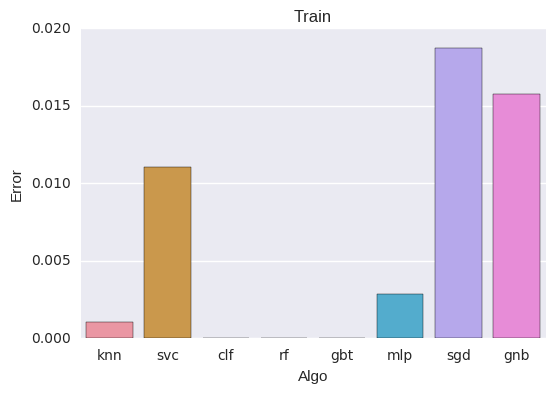

In [90]:
ax = sns.barplot(x=data_names, y=data_values_train)
ax.set(title='Train', xlabel='Algo', ylabel='Error')

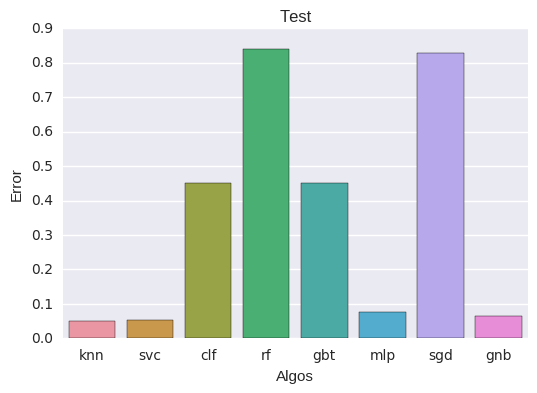

In [91]:
ax = sns.barplot(x=data_names, y=data_values_test)
ax.set(title='Test', xlabel='Algos', ylabel='Error')